In this problem, you are going to implement the A* algorithm from scratch to find the shortest path between two locations in California's road network from the United States Census Bureau. 

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, andfunctions of complex networks.   https://networkx.org/

You need Smopy for this problem. You can install it with 
pip install git+https://github.com/rossant/smopy. 
In order for NetworkX to read Shapefile datasets, you also need GDAL/OGR. You can install it with 
conda install gdal.

In [136]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt

We load the data (a Shapefile dataset) with NetworkX. This dataset contains detailed information about the primary roads in California. NetworkX's read_shp() function returns a graph, where each node is a geographical position, and each edge contains information about the road linking the two nodes.

In [137]:
url = ('https://github.com/ipython-books/'
       'cookbook-2nd-data/blob/master/'
       'road.zip?raw=true')
r = io.BytesIO(requests.get(url).content)
zipfile.ZipFile(r).extractall('data')
g = nx.read_shp('data/tl_2013_06_prisecroads.shp')
print(g)

C:\Users\pthak\AppData\Local\Temp/ipykernel_8252/3414892297.py:6: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  g = nx.read_shp('data/tl_2013_06_prisecroads.shp')


DiGraph with 7242 nodes and 6563 edges


In [138]:
# g.nodes
len(g.nodes)
# Nodes : (((-118.395179, 37.361458999999996)))
# g.edges
# Edeges : [((-118.395179, 37.361458999999996), (-118.395325, 37.37579699999999))]

7242

464


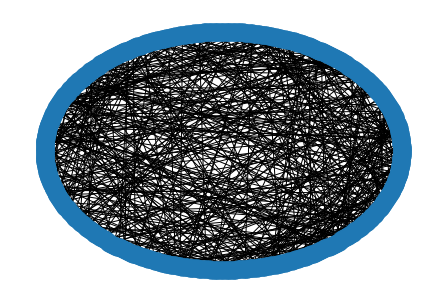

In [139]:
B = g.to_undirected()
sgs = list(B.subgraph(c) for c in nx.connected_components(B))
# sg = max(nx.weakly_connected_components(g), key=len)
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)
print(len(sg))
# print(sg.nodes)
nx.draw_circular(sg)
# print(sg.edges)

In [140]:
G = nx.Graph()
G.add_nodes_from([i for i in range(0, 128)])

This graph is not necessarily connected, but we need a connected graph in order to compute shortest paths. Here, we take the largest connected subgraph using the connected_component_subgraphs() function:

In [141]:
# sgs = list(nx.connected_component_subgraphs(
#     g.to_undirected()))
# i = np.argmax([len(sg) for sg in sgs])
# sg = sgs[i]
# len(sg)


We define two positions (with the latitude and longitude) and find the shortest path between these two positions:

In [142]:
pos0 = (37.6026, -121.9926)
# pos00 = (-121.9926, 37.6026)
pos1 = (34.0569, -118.2427)
# pos11 = (-118.2427, 34.0569)

Each edge in the graph contains information about the road, including a list of points along this road. We first create a function that returns this array of coordinates, for any edge in the graph:

In [143]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

We can notably use the road path to compute its length. We first need to define a function that computes the distance between any two points in geographical coordinates:

In [144]:
# from [https://stackoverflow.com/a/8859667/1595060](https://stackoverflow.com/a/8859667/1595060)
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

Now, we define a function computing a path's length:

In [145]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))


We update our graph by computing the distance between any two connected nodes. We add this information with the distance attribute of the edges:

In [146]:
# Compute the length of the road segments.

for n0, n1 in sg.edges:
    print(n0, n1)
    path = get_path(n0, n1)
    print("Path : ", path)
    distance = get_path_length(path)
    print("Distance : ", distance)
    sg.edges[n0, n1]['distance'] = distance


(-121.586642, 39.14501299999999) (-121.59112900000001, 39.14465899999999)
Path :  [[-121.586642   39.145013]
 [-121.586783   39.144991]
 [-121.587208   39.144926]
 [-121.58735    39.144905]
 [-121.587504   39.144893]
 [-121.587967   39.144859]
 [-121.588122   39.144848]
 [-121.588391   39.144847]
 [-121.588547   39.144837]
 [-121.588739   39.144825]
 [-121.588855   39.144819]
 [-121.589009   39.1448  ]
 [-121.589157   39.144783]
 [-121.589477   39.144756]
 [-121.589633   39.144743]
 [-121.589784   39.144733]
 [-121.590239   39.144703]
 [-121.59039    39.144694]
 [-121.590551   39.144684]
 [-121.590717   39.144674]
 [-121.591034   39.144663]
 [-121.591129   39.144659]]
Distance :  0.3895522448606451
(-121.586642, 39.14501299999999) (-121.586685, 39.14532899999999)
Path :  [[-121.586642   39.145013]
 [-121.586672   39.145236]
 [-121.586685   39.145329]]
Distance :  0.03534276674971819
(-120.783863, 38.73261699999999) (-121.08555600000001, 38.648096999999986)
Path :  [[-120.783863   38.73

The last step before we can find the shortest path in the graph is to find the two nodes in the graph that are closest to the two requested positions:

In [147]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
print(pos0_i)
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))
print(pos1_i)

357
80


TODO: implement A* algorithm from scratch

In [148]:
#TODO implement A* algorithm from scratch
# And implement the Heuristic function.

from heapq import heappush, heappop
from itertools import count
import math

#Please define your heuristic and explain why
"""As far as I know there are THREE different major types of Heuristic available 
1.Euclidian distance (Normal Distance)
2.Manhattan distance (Mostly used for the Grid World)
3.Great circle distance (Circular grid world)

I have used Euclidian Distance heuristic here because we have Map and their edges available.
"""

# Euclidian Distance Heuristic function.
def euDistHeuristic(a, b):
	(x1, y1), (x2, y2) = tuple(nodes[pos0_i]), tuple(nodes[pos1_i])
	return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
# def astar_path()
def astar_path(G, source, target, weight):
    """Return a list of nodes in a shortest path between source and target
    using the A* ("A-star") algorithm.

    There may be more than one shortest path.  This returns only one.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Starting node for path

    target : node
       Ending node for path

    heuristic : function
       A function to evaluate the estimate of the distance
       from the a node to the target.  The function takes
       two nodes arguments and must return a number.

    weight: string, optional (default='weight')
       Edge data key corresponding to the edge weight.

    """
    push = heappush
    pop = heappop

    # The queue stores priority, node, cost to reach, and parent.
    # Uses Python heapq to keep in priority order.
    # Add a counter to the queue to prevent the underlying heap from
    # attempting to compare the nodes themselves. The hash breaks ties in the
    # priority and is guarenteed unique for all nodes in the graph.
    c = count()
    queue = [(0, next(c), source, 0, None)]

    # Maps enqueued nodes to distance of discovered paths and the
    # computed heuristics to target. We avoid computing the heuristics
    # more than once and inserting the node into the queue too many times.
    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}

    while queue:
        # Pop the smallest item from queue.
        _, __, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path

        if curnode in explored:
            continue

        explored[curnode] = parent

        for neighbor, w in G[curnode].items():
            if neighbor in explored:
                continue
            ncost = dist + w.get(weight, 1)
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                # if qcost < ncost, a longer path to neighbor remains
                # enqueued. Removing it would need to filter the whole
                # queue, it's better just to leave it there and ignore
                # it when we visit the node a second time.
                if qcost <= ncost:
                    continue
            else:
                h = euDistHeuristic(neighbor, target)
            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

TODO: use A* algorithm to find the shortest path. Once the itinerary has been computed, the path variable should contain the list of edges that form the shortest path between our two positions.

In [149]:
#TODO use A* algorithm to find the shortest path

path = astar_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight ='distance'
)
len(path)

26

Now, we can get information about the itinerary with pandas. The dataset has a few fields of interest, including the name and type (State, Interstate, and so on) of the roads:

In [150]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,17.371936
1,Cabrillo Hwy,S1200,M,1.161328
2,Cabrillo Hwy,S1200,M,0.416819
3,Cabrillo Hwy,S1200,M,8.830300
4,Cabrillo Hwy,S1200,M,4.710562
5,State Rte 1,S1200,S,26.979412
6,State Rte 1,S1200,S,119.835869
7,State Rte 1,S1200,S,37.559920
8,Cabrillo Hwy,S1200,M,4.412885
9,State Rte 1,S1200,S,13.486984


In [151]:
roads['distance'].sum()

592.6194488934598

Finally, let's display the itinerary on the map. We first retrieve the map with Smopy:

In [152]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

Our path contains connected nodes in the graph. Every edge between two nodes is characterized by a list of points (constituting a part of the road). Therefore, we need to define a function that concatenates the positions along every edge in the path. We have to concatenate the positions in the right order along our path. We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge:

In [153]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

 We convert the path in pixels in order to display it on the Smopy map:

In [154]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

Finally, let's display the map, with our two positions and the computed itinerary between them:

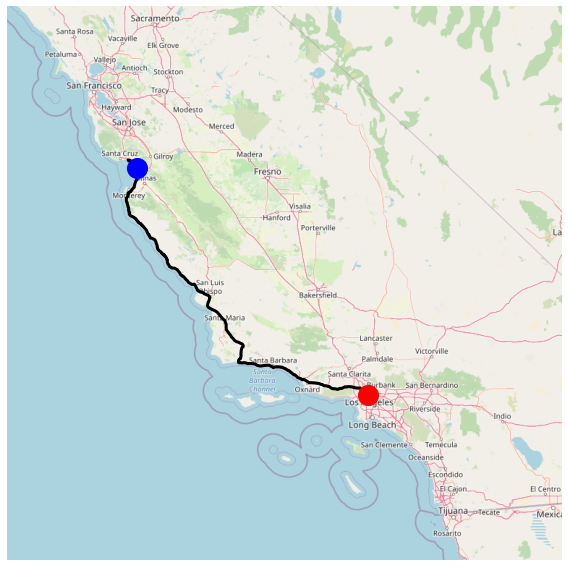

In [155]:
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)